#Measuring and Mitigating Biases with AI using FairLearn

This notebook aims to measure and mitigate biases within ML models using the Fairlearn package created by Microsoft. This colab notebook will be covering the biases within the adult dataset

# Initalisation

In [ ]:
#importing needed libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from yellowbrick.classifier import ClassificationReport
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
#loading the dataset to be used
adult = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diss/adult.csv')


#Building Adult Machine Learning Model

This section contains the development of the Machine Learning model before any bias mitigation

## Initalisation of the datasets


In [ ]:
# displaying dataset before any preprocessing technqiues
adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Renaming income as the target variable




In [ ]:
#renaiming income to target variable
adult = adult.rename(columns={
    'income' : 'target'
})

adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## EDA

#### Correlation

The correlation matrix code only runs after peforming one hot encoding

In [ ]:
#calulates the correlation matrix for adult dataset
correlation_matrix = adult.corr()
#plots the size of the figure
plt.figure(figsize=(12, 8))
# hides the upper half of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
#heatmap to easily diffrintiate between postive and negative correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
#titling
plt.title('Correlation Matrix')


plt.show()

ValueError: could not convert string to float: ' State-gov'

Discription of the attributes

In [ ]:
adult.describe()

<BarContainer object of 2 artists>

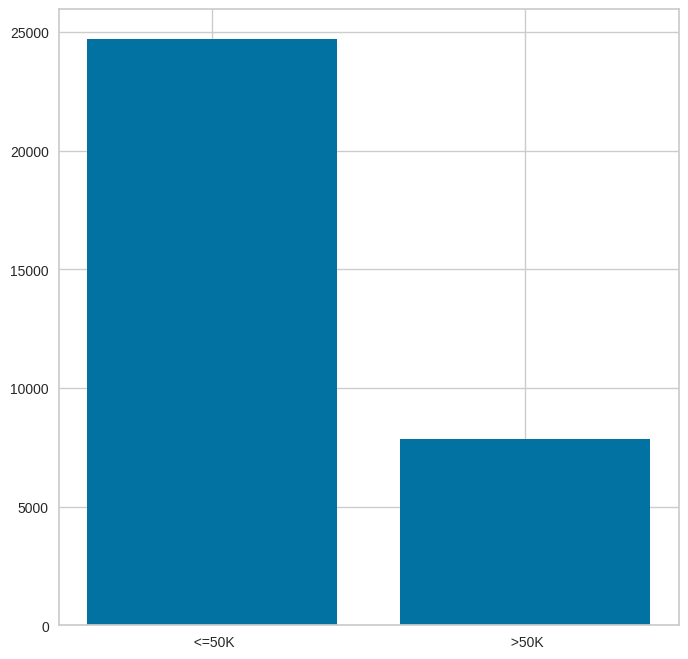

In [ ]:
y = adult['target']
distribution = y.value_counts()
plt.figure(figsize=(8, 8))
plt.bar(distribution.index, distribution.values)

In [ ]:
adult['target'].value_counts()

target
 <=50K    24720
 >50K      7841
Name: count, dtype: int64

#### Distribution of attributes grouped by target

Distribution of race

In [ ]:
sns.catplot(x='race', kind='count', hue='target', data=adult)
plt.xticks(rotation=45) #to fix the label overlapping

Distribution of sex

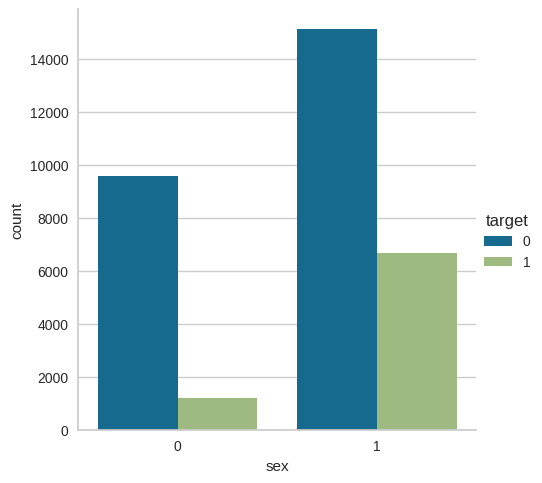

In [ ]:
sns.catplot(x='sex', kind='count', hue='target', data=adult)

Distribution of marital status

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

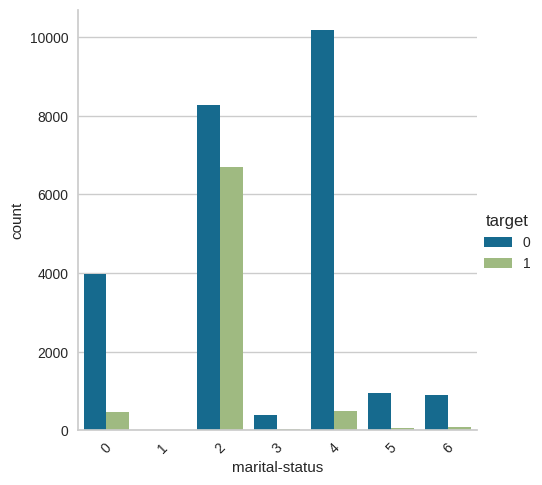

In [ ]:
sns.catplot(x='marital-status', kind='count', hue='target', data=adult)
plt.xticks(rotation=45) #to fix the label overlapping

In [ ]:
#calulating the average age within each target group
average_age_by_income = adult.groupby('target')['age'].mean()
print(average_age_by_income)


target
0    19.782322
1    27.248820
Name: age, dtype: float64


Age vs target

In [ ]:
sns.boxplot(x = 'age', hue='target',  data=adult)

Distribution of relationship by sex

In [ ]:
sns.displot(adult, x='relationship', hue='sex', kind='hist',
            multiple="stack", aspect=1.2, shrink=.8)
plt.title('Distribution of Relationship Status by Sex')
plt.show()


Relationship status vs target

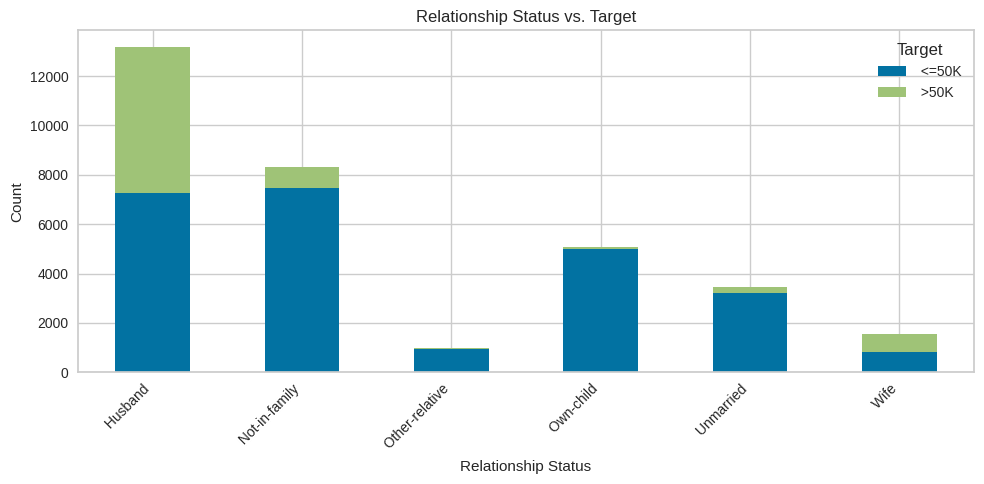

In [ ]:
contingency_table = pd.crosstab(adult['relationship'], adult['target'])

contingency_table.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel('Relationship Status')
plt.ylabel('Count')
plt.title('Relationship Status vs. Target')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

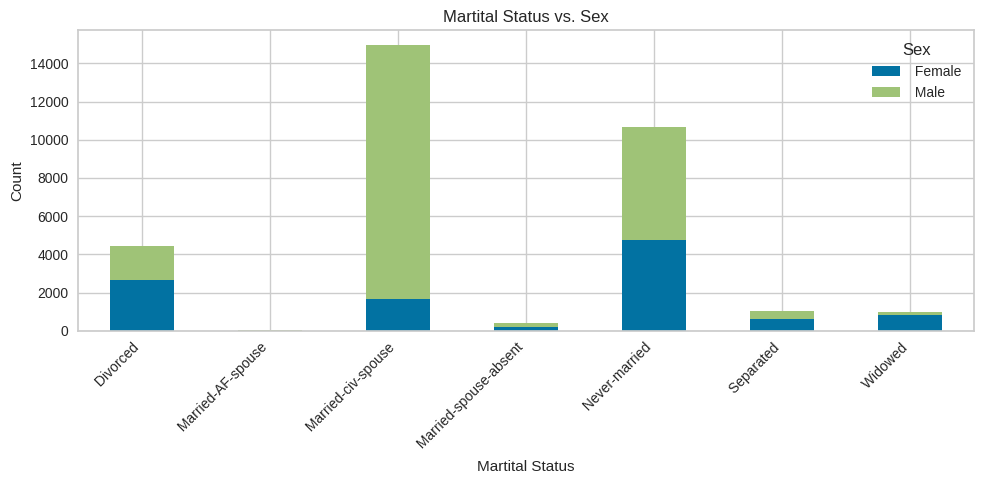

In [ ]:
contingency_table = pd.crosstab(adult['marital-status'], adult['sex'])

contingency_table.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel('Martital Status')
plt.ylabel('Count')
plt.title('Martital Status vs. Sex')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

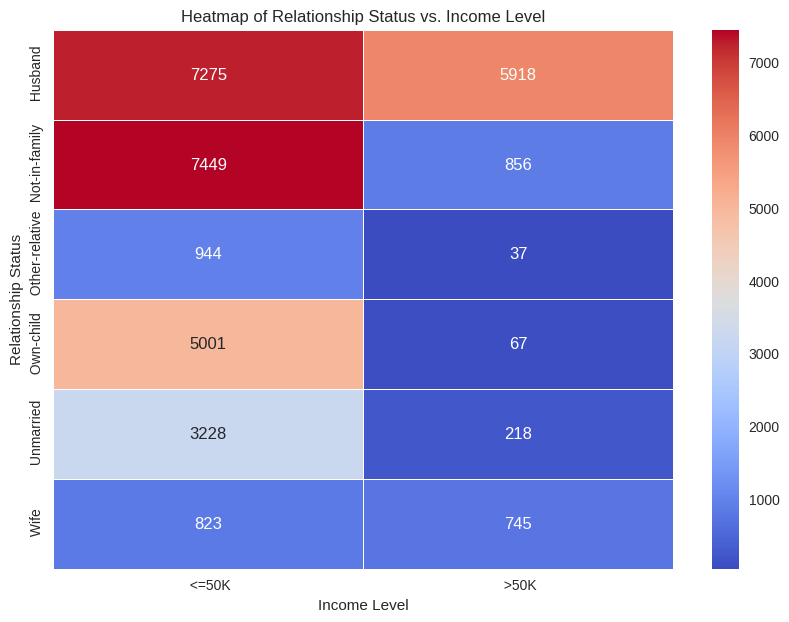

In [ ]:
# Creating a contingency table for relationships and target
contingency_table = pd.crosstab(adult['relationship'], adult['target'])


# Plotting the contingency table as a heatmap for visualization
plt.figure(figsize=(10, 7))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap='coolwarm', linewidths=0.5) #fmt="d" annotates with whole numbers
plt.title('Heatmap of Relationship Status vs. Income Level')
plt.ylabel('Relationship Status')
plt.xlabel('Income Level')
plt.show()


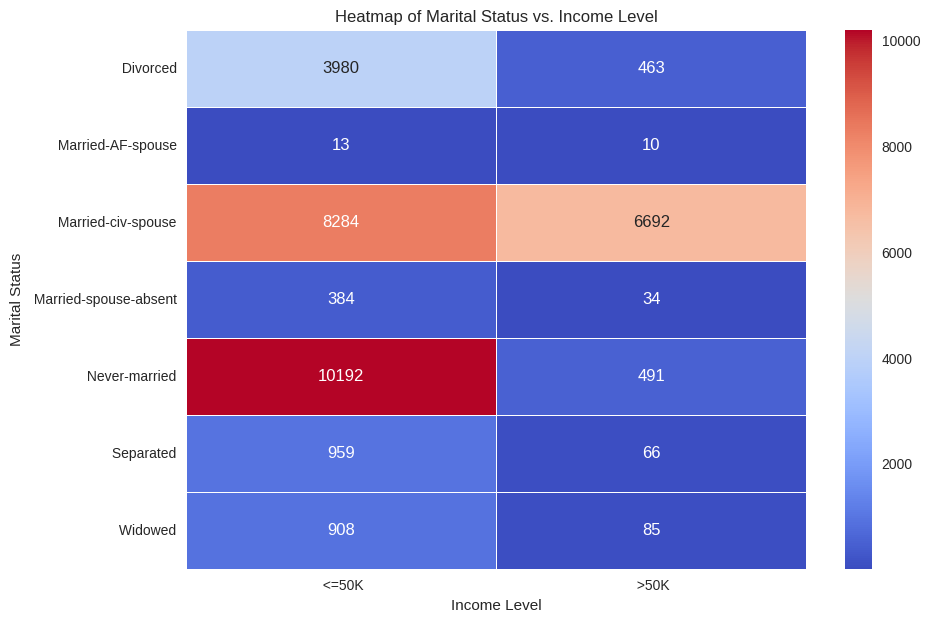

In [ ]:
# Creating a contingency table for marital status and target
contingency_table = pd.crosstab(adult['marital-status'], adult['target'])


# Plotting the contingency table as a heatmap for visualization
plt.figure(figsize=(10, 7))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap='coolwarm', linewidths=0.5) #fmt="d" annotates with whole numbers
plt.title('Heatmap of Marital Status vs. Income Level')
plt.ylabel('Marital Status')
plt.xlabel('Income Level')
plt.show()

code (Pipis, 2020)

In [ ]:
from scipy.stats import chi2_contingency
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test Results:")
print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected Frequencies if No Association:")
print(pd.DataFrame(expected, columns=contingency_table.columns, index=contingency_table.index))


Chi-Square Test Results:
Chi-Square Statistic: 6517.741653663022
P-value: 0.0
Degrees of Freedom: 6

Expected Frequencies if No Association:
target                         <=50K         >50K
marital-status                                   
 Divorced                3373.083136  1069.916864
 Married-AF-spouse         17.461380     5.538620
 Married-civ-spouse     11369.636068  3606.363932
 Married-spouse-absent    317.341605   100.658395
 Never-married           8110.431498  2572.568502
 Separated                778.170204   246.829796
 Widowed                  753.876109   239.123891


In [ ]:
contingencytable = pd.crosstab(adult['marital-status'], adult['target'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingencytable)
print("\nChi-Square Test Results:")
print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected Frequencies if No Association:")
print(pd.DataFrame(expected, columns=contingencytable.columns, index=contingencytable.index))


Chi-Square Test Results:
Chi-Square Statistic: 6517.741653663022
P-value: 0.0
Degrees of Freedom: 6

Expected Frequencies if No Association:
target                     0            1
marital-status                           
0                3373.083136  1069.916864
1                  17.461380     5.538620
2               11369.636068  3606.363932
3                 317.341605   100.658395
4                8110.431498  2572.568502
5                 778.170204   246.829796
6                 753.876109   239.123891


## Feature Engineering

### Empty Rows/ Invalid Rows replacement

In [ ]:
adult.replace(' ?', pd.NA, inplace=True)


calulating the mode of each atrribute so i can replace the empty values with the mode

In [ ]:
adult.mode()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,target
0,36.0,Private,123011,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
1,NaN,NaN,164190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,203488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# This is to check wether the dataset has any missing values
missing= adult.isna().sum()
print (missing)

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
captial-loss         0
hours-per-week       0
native-country     583
target               0
dtype: int64


In [ ]:
# replacing the empty values
adult['workclass'].fillna('Private', inplace=True)
adult['occupation'].fillna('Prof-specialty', inplace=True)
adult['native-country'].fillna('United-States', inplace=True)

In [ ]:
# This is to check wether the dataset has any missing values
missing= adult.isna().sum()
print (missing)


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
captial-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64


Checking for duplicated rows

In [ ]:
duplicates = adult.duplicated()
duplicates.sum()

24

### One hot encoding (Brownlee, 2020)

In [ ]:
#creating a list of all columns within the dataset
columns = adult.columns.tolist()
#The encoder - encodes values between 1 and number of columns - 1
encoder = LabelEncoder()

#for loop encoding all columns within the dataset
for i in range(len(columns)):
  adult[columns[i]] = encoder.fit_transform(adult[columns[i]])

#Displays the encoded dataset
adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,target
0,22,6,2671,9,12,4,0,1,4,1,25,0,39,38,0
1,33,5,2926,9,12,2,3,0,4,1,0,0,12,38,0
2,21,3,14086,11,8,0,5,1,4,1,0,0,39,38,0
3,36,3,15336,1,6,2,5,0,2,1,0,0,39,38,0
4,11,3,19355,9,12,2,9,5,2,0,0,0,39,4,0


## Preprocessing


### Splitting the dataset

In [ ]:
#splitting the dataset into features and target
X = adult.drop('target', axis = 1)
y = adult['target']
#spliting data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 42)

x_test_bias = X_test #creating a copy of x test for later bias EDA

# The following is the shapes of the individulal train and test sets for x and y
X_train.shape

(26048, 14)

In [ ]:
#The dataset is unbalanced - oversampling to balance target values
from imblearn.over_sampling import SMOTE
over = SMOTE()
X_train, y_train = over.fit_resample(X_train, y_train)

#creating new dataframe with the balanced train data
#X_train_df = pd.DataFrame(X_train, columns=X.columns)
#y_train_df = pd.DataFrame(y_train, columns=['target'])

#df = pd.concat([X_train_df, y_train_df], axis=1)

In [ ]:
#standardising training data for the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
X_test.shape

(6513, 14)

In [ ]:
y_train.shape

(39556,)

In [ ]:
y_test.shape

(6513,)

In [ ]:
# checking the balance of the target variable
y_test.value_counts()

target
0    4942
1    1571
Name: count, dtype: int64

In [ ]:
y_train.value_counts()

target
1    19778
0    19778
Name: count, dtype: int64

## ML Models

### Random Forest Model

In [ ]:
# RFM for the dataset

#defining the RFM model -  specifying the number of trees in the RM (100)
clf_rf = RandomForestClassifier(n_estimators=200)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print(rf_acc)

0.8464609243052357


### Gradient Boosting Classifier

An ensemble model

In [ ]:
from xgboost import XGBClassifier

GBC = XGBClassifier(n_estimators=100)
GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_test)
gbc_acc = accuracy_score(y_test, y_pred)
print(gbc_acc)

0.8645785352372178


### Suport Vector Machine Model

SVM is a good algorithm for unbalanced datasets, but in this case the GBC Model outperforms therfore for this project GBC Model will be used

In [ ]:
# Support Vector Machine Model
clf_svm = SVC()
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred)
print(svm_acc)

0.8240442192538001


#### Cross validation


In [ ]:
#defining the amount of folds to use in CV -  this defines how many times the model is trained

#Performing CV
cv_scores = cross_val_score(GBC, X_train, y_train, cv=5)
print(cv_scores)



[0.77704752 0.86196435 0.93414233 0.93439515 0.93072936]


In [ ]:
y_pred = cross_val_predict(GBC, X_test, y_test, cv=5)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Cross-validated Accuracy:", accuracy)

Cross-validated Accuracy: 0.855366190695532


### Hyperparameter tuning

This section will involve using GridSearchCV to find the best parameters for my machine learning model to improve the accuracy score

In [ ]:
from sklearn.model_selection import GridSearchCV

#Different parameters to iterate from
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'n_estimators': [100, 200, 300]
}

#intialising the grid search
grid_search = GridSearchCV(GBC, param_grid, cv=5, scoring='accuracy')

#performing the grid search
grid_search.fit(X_train, y_train)

#getting the best params
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#using the best model for the prediction
y_pred = best_model.predict(X_test)

#calulating the new accuracy score
gbc_acc = accuracy_score(y_test, y_pred)
print("Improved Gradient Boosting Classifier accuracy:", gbc_acc)

This section is using a randomised paramater search while using Cross Validation. Random search is utilized as it has a shorter processing time compared to GridSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint #for randomised numbers

param= {
    'n_estimators': randint(50, 150), # random number from 50 - 150
    'max_depth': [None, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2]
}

random = RandomizedSearchCV(estimator=GBC,
                            param_distributions=param,
                            n_iter=10, cv =6, scoring= 'accuracy',
                            random_state=42)

random.fit(X_train, y_train)

best_params = random.best_params_
best_estimator = random.best_estimator_

In [ ]:
print(best_params)

In [ ]:
y_pred = best_estimator.predict(X_test)
gbc_acc = accuracy_score(y_test, y_pred)
print("Improved Gradient Boosting Classifier accuracy:", gbc_acc)

In [ ]:
#classifiction report
report = classification_report(y_test, y_pred, target_names=['Under 50K','Over 50k'], output_dict=True)

#formating
def format_classification_report(report):
    formatted_report = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}\n"
    for class_name, metrics in report.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        formatted_report += f"{class_name:<15}{metrics['precision']:.2f}{' ' * 6}{metrics['recall']:.2f}{' ' * 6}{metrics['f1-score']:.2f}{' ' * 6}{metrics['support']}\n"
    return formatted_report

# Print the formatted report
print(format_classification_report(report))

Class          Precision Recall    F1-Score  Support   
Under 50K      0.91      0.90      0.91      4942
Over 50k       0.71      0.74      0.72      1571



Note: Hyperparamter tuning and CV was not used in the final model as it decreased the accuracy value

### Feature Importance
 This section will be covering the features that are most important on predicting wether someones income is over 50K or not

In [ ]:
# caluslating the most important features when using the GBC model for predictions
importances = GBC.feature_importances_

In [ ]:
# labeling the columns
featureIm = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

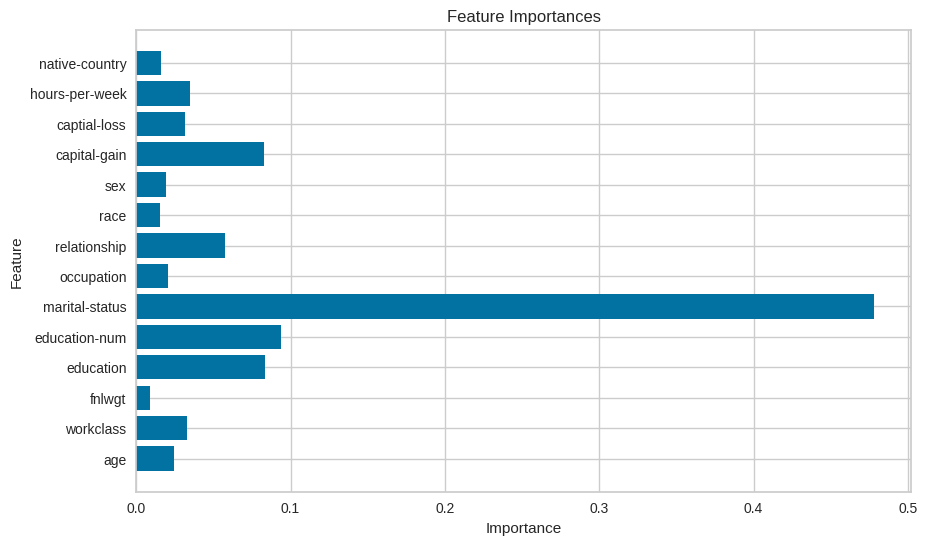

In [ ]:
# plotting a barchart on the importance comparing the values between the other features
plt.figure(figsize=(10, 6))
plt.barh(featureIm['Feature'], featureIm['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#Fairlearn

### EDA for ML Model

This section will be analysing the prediction from the machine learning model to see how biased the outcomes are

In [ ]:
# creating a new dataset with the predidct values of Y to be able to compare the target distribution of predicted y

x_test_bias['pred'] = y_pred

x_test_bias.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,pred
14160,10,3,8535,15,9,0,0,1,4,0,0,0,37,38,0
27048,28,6,1549,11,8,2,3,5,4,0,0,0,39,38,0
28868,12,3,11163,9,12,2,3,0,2,1,0,0,54,38,1
5667,13,3,11641,9,12,4,6,1,4,0,0,0,39,38,0
7827,12,5,11564,15,9,0,2,1,4,1,27,0,49,38,0


In [ ]:
x_test_bias.describe()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,captial-loss,hours-per-week,native-country,pred
count,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.00000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000
mean,21.600798,3.396745,10490.775065,10.339628,9.081222,2.608475,6.46507,1.463688,3.675111,0.673576,6.811147,2.046062,39.574697,36.572701,0.253493
std,13.626411,1.592790,6074.260438,3.866013,2.562967,1.521832,4.33513,1.611616,0.843800,0.468940,23.725083,10.245348,12.211901,5.889021,0.435044
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,3.000000,5354.000000,9.000000,8.000000,2.000000,3.00000,0.000000,4.000000,0.000000,0.000000,0.000000,39.000000,38.000000,0.000000
50%,20.000000,3.000000,10415.000000,11.000000,9.000000,2.000000,7.00000,1.000000,4.000000,1.000000,0.000000,0.000000,39.000000,38.000000,0.000000
75%,31.000000,3.000000,15496.000000,12.000000,11.000000,4.000000,10.00000,3.000000,4.000000,1.000000,0.000000,0.000000,44.000000,38.000000,1.000000
max,72.000000,8.000000,21644.000000,15.000000,15.000000,6.000000,14.00000,5.000000,4.000000,1.000000,118.000000,91.000000,93.000000,41.000000,1.000000


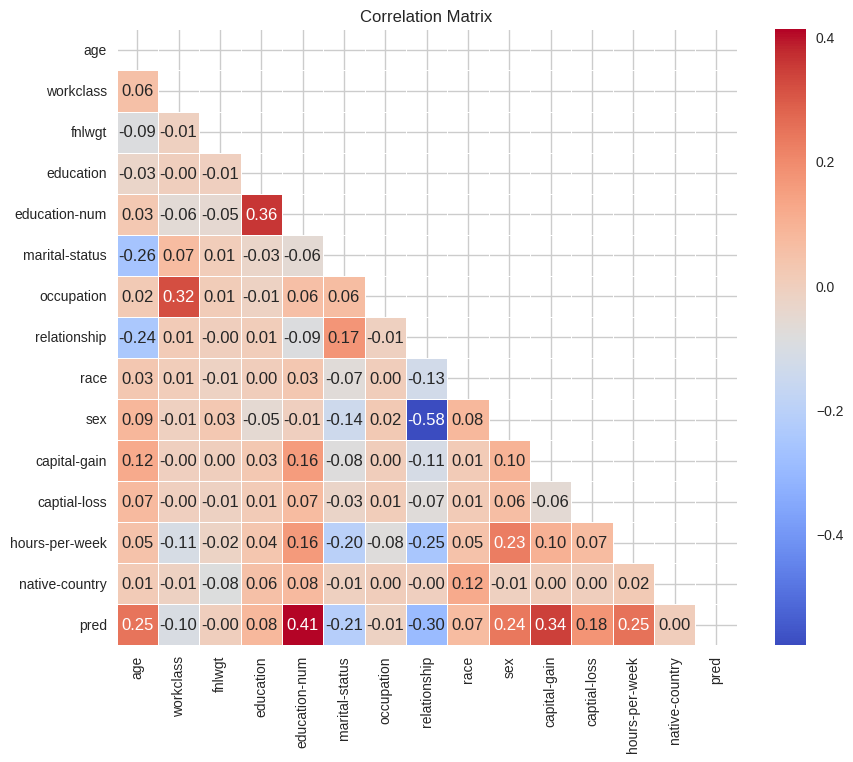

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = x_test_bias.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask = mask)
plt.title('Correlation Matrix')
plt.show()

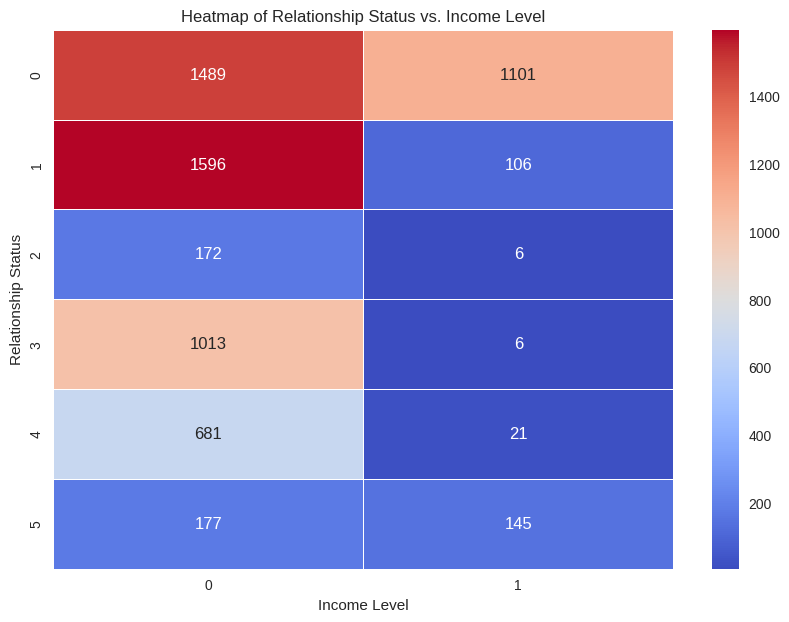

In [ ]:
# Creating a contingency table for relationships and target
contingency_table = pd.crosstab(x_test_bias['relationship'], x_test_bias['pred'])


# Plotting the contingency table as a heatmap for visualization
plt.figure(figsize=(10, 7))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap='coolwarm', linewidths=0.5) #fmt="d" annotates with whole numbers
plt.title('Heatmap of Relationship Status vs. Income Level')
plt.ylabel('Relationship Status')
plt.xlabel('Income Level')
plt.show()

In [ ]:
x_test_bias['sex'] = x_test_bias['sex'].replace({0: 'Female', 1: 'Male'})
x_test_bias['pred'] = x_test_bias['pred'].replace({0: '<=50K', 1: '>50K'})

Text(0.5, 1.0, 'Sex Distribution')

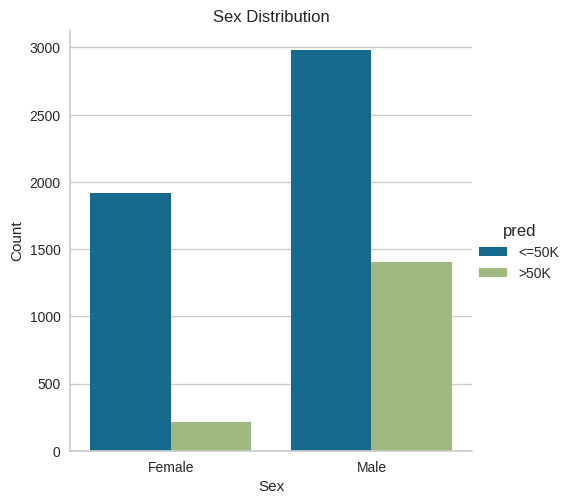

In [ ]:
sns.catplot(x='sex', kind='count', hue='pred', data=x_test_bias)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Distribution')

## Initaisation






In [ ]:
pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
# importing packages needed
from fairlearn.metrics import MetricFrame, demographic_parity_difference, selection_rate, equalized_odds_difference, true_positive_rate_difference
from fairlearn.reductions import DemographicParity, ExponentiatedGradient,EqualizedOdds, GridSearch, SquareLoss
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)




## Bias measurement


### EDA of the predicted values before mitigation

In [ ]:
sensitive_feature = x_test_bias['marital-status']

demographic_parity_difference(y_true = y_test,
                             y_pred = y_pred,
                             sensitive_features=sensitive_feature)


0.973659454374412

In [ ]:
sensitive_feature = x_test_bias['relationship']

demographic_parity_difference(y_true = y_test,
                             y_pred = y_pred,
                             sensitive_features=sensitive_feature)

0.4965088037708254

In [ ]:
sensitive_feature = x_test_bias['race']

demographic_parity_difference(y_true = y_test,
                             y_pred = y_pred,
                             sensitive_features=sensitive_feature)

0.21733396137541217

In [ ]:
sensitive_feature = x_test_bias['sex']

demographic_parity_difference(y_true = y_test,
                             y_pred = y_pred,
                             sensitive_features=sensitive_feature)

0.21786918117992074

In [ ]:
metrics = {
    "accuracy": accuracy_score,
    "selection rate": selection_rate, # calculates the precentage of those who have 50k>
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
}

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

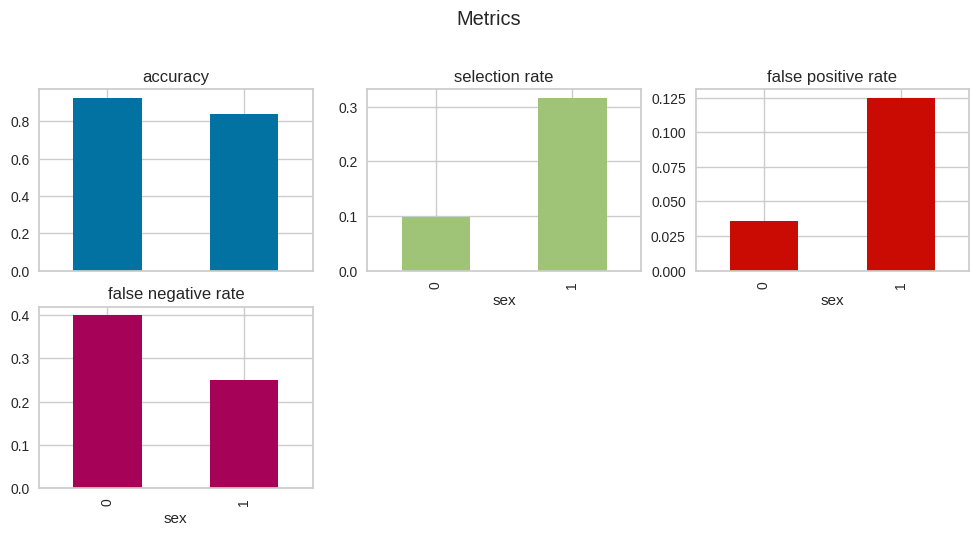

In [ ]:
mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics",
)


array([[<Axes: title={'center': 'accuracy'}, xlabel='relationship'>,
        <Axes: title={'center': 'precision'}, xlabel='relationship'>,
        <Axes: title={'center': 'selection rate'}, xlabel='relationship'>],
       [<Axes: title={'center': 'recall'}, xlabel='relationship'>,
        <Axes: title={'center': 'f1'}, xlabel='relationship'>,
        <Axes: xlabel='relationship'>],
       [<Axes: xlabel='relationship'>, <Axes: xlabel='relationship'>,
        <Axes: xlabel='relationship'>]], dtype=object)

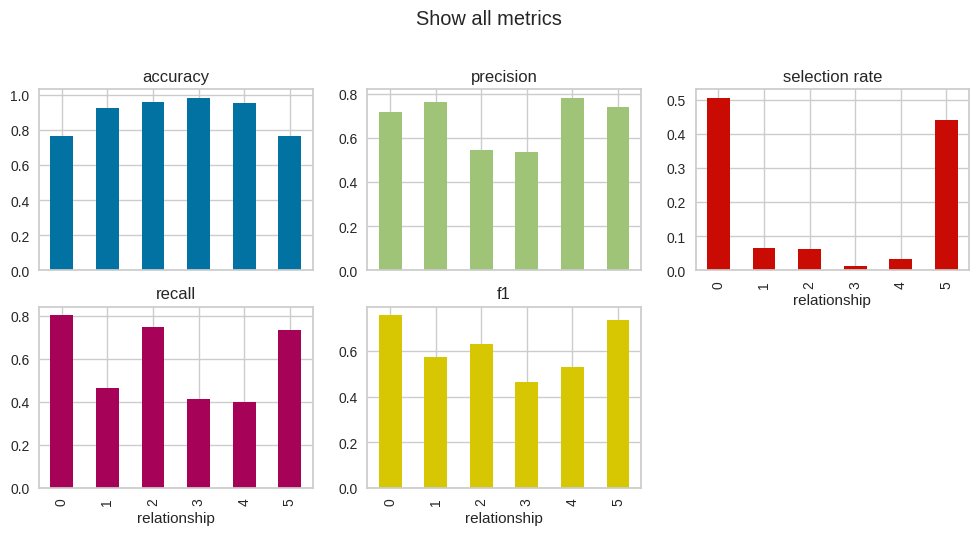

In [ ]:

mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=x_test_bias['relationship'])

mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

array([[<Axes: title={'center': 'accuracy'}, xlabel='marital-status'>,
        <Axes: title={'center': 'precision'}, xlabel='marital-status'>,
        <Axes: title={'center': 'selection rate'}, xlabel='marital-status'>],
       [<Axes: title={'center': 'recall'}, xlabel='marital-status'>,
        <Axes: title={'center': 'f1'}, xlabel='marital-status'>,
        <Axes: xlabel='marital-status'>],
       [<Axes: xlabel='marital-status'>, <Axes: xlabel='marital-status'>,
        <Axes: xlabel='marital-status'>]], dtype=object)

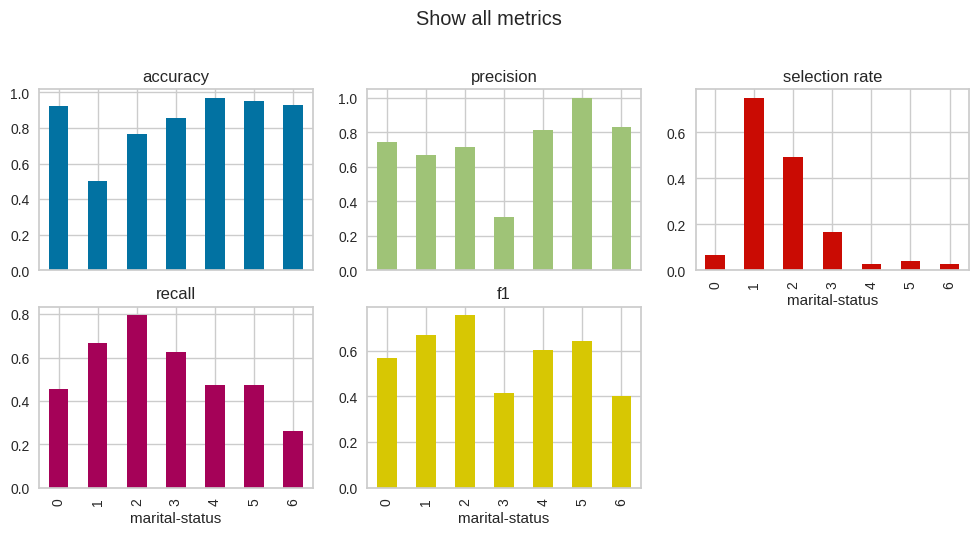

In [ ]:
mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=x_test_bias['marital-status'])

mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

## Bias mitigation

In [ ]:
X = adult.drop('target', axis = 1)
y = adult['target']
#spliting data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 42)


#### Marital Status

In [ ]:
sensitive_feature = X_test['marital-status']

demographic_parity_difference(y_true = y_test,
                             y_pred = y_pred,
                             sensitive_features=sensitive_feature)

0.973659454374412

In [ ]:
#Exponentiated Gradient adjusts the weights of the training samples based on
#the demophraphic parity to make sure samples from under represented groups
#are given higher importance
#mitigator ajusts the weighting in the GBC model based on the DP
mitigator = ExponentiatedGradient(estimator= GBC,
                                  constraints= DemographicParity())
sensitive_feature = X_train['marital-status']
nw =mitigator.fit(X_train, y_train, sensitive_features=sensitive_feature)
y_bias = nw.predict(X_test)

In [ ]:
sensitive_feature = X_test['marital-status']
mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_bias, sensitive_features=sensitive_feature)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mf.overall

accuracy          0.804545
precision         0.683498
selection rate    0.124674
recall            0.353278
f1                0.465799
dtype: float64

In [ ]:
mf.by_group

,accuracy,precision,selection rate,recall,f1
marital-status,,,,,
0,0.898913,0.545455,0.119565,0.582524,0.563380
1,0.250000,0.000000,0.000000,0.000000,0.000000
2,0.682712,0.989691,0.131525,0.291793,0.450704
3,0.895833,0.416667,0.125000,0.625000,0.500000
4,0.906867,0.315175,0.120884,0.786408,0.450000
5,0.933014,0.608696,0.110048,0.736842,0.666667
6,0.908654,0.500000,0.105769,0.578947,0.536585


In [ ]:
demographic_parity_difference(y_true = y_test,
                             y_pred = y_bias,
                             sensitive_features=sensitive_feature)

0.13152542372881357

#### Sex

In [ ]:
sensitive_feature = X_test['sex']

demographic_parity_difference(y_true = y_test,
                             y_pred = y_pred,
                             sensitive_features=sensitive_feature)

0.21786918117992074

In [ ]:
mitigator = ExponentiatedGradient(estimator= GBC,
                                  constraints= DemographicParity())
sensitive_feature = X_train['sex']
nw =mitigator.fit(X_train, y_train, sensitive_features=sensitive_feature)
y_bias = nw.predict(X_test)

In [ ]:
sensitive_feature = X_test['sex']
mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_bias, sensitive_features=sensitive_feature)
mf.overall

accuracy               0.850760
selection rate         0.187471
false positive rate    0.062930
false negative rate    0.420751
dtype: float64

In [ ]:
mf.by_group


,accuracy,selection rate,false positive rate,false negative rate
sex,,,,
0,0.881468,0.185795,0.10935,0.193133
1,0.835879,0.188284,0.03411,0.460389


In [ ]:
demographic_parity_difference(y_true = y_test,
                             y_pred = y_bias,
                             sensitive_features=sensitive_feature)

0.0024140210718360533

##### Equalized odds

In [ ]:
equalized_odds_difference(y_true=y_test,
                          y_pred=y_pred,
                          sensitive_features=sensitive_feature)

0.15026270713447132

In [ ]:
equalized_odds_difference(y_true=y_test,
                          y_pred=y_bias,
                          sensitive_features=sensitive_feature)

0.2967435862891895

In [ ]:
constraints = EqualizedOdds(difference_bound=1) #sets the maximum difference between each group - 5% is selected
sensitive_feature = X_train['sex']
mitigator = GridSearch(estimator=GBC, constraints=constraints, selection_rule='tradeoff_optimization')
eo =mitigator.fit(X_train, y_train, sensitive_features=sensitive_feature)
#y_bias = eo.predict(X_test)

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
print(mitigator.grid)

None


In [ ]:
sensitive_feature = X_test['sex']
mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_bias, sensitive_features=sensitive_feature)
mf.overall

accuracy               0.852295
selection rate         0.187164
false positive rate    0.061716
false negative rate    0.418205
dtype: float64

In [ ]:
mf.by_group

,accuracy,selection rate,false positive rate,false negative rate
sex,,,,
0,0.886642,0.183443,0.105124,0.180258
1,0.835651,0.188967,0.034765,0.459641


Text(0.5, 1.0, 'Sex Distribution After Mitigation')

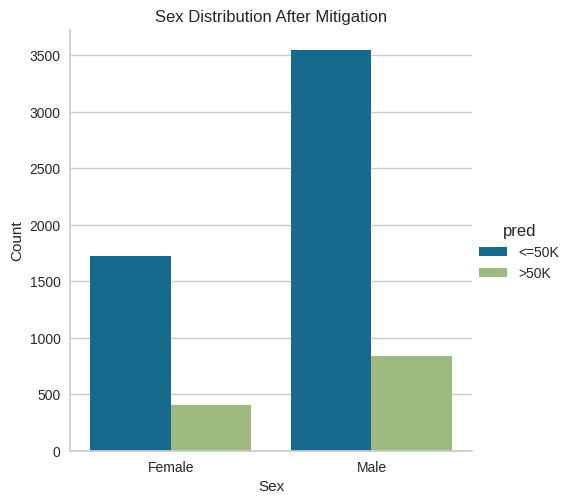

In [ ]:
compare = X_test['pred'] = y_bias
X_test['sex'] = X_test['sex'].replace({0: 'Female', 1: 'Male'})
X_test['pred'] = X_test['pred'].replace({0: '<=50K', 1: '>50K'})
sns.catplot(x='sex', kind='count', hue='pred', data=X_test)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Distribution After Mitigation')

#### Relationship

In [ ]:
sensitive_feature = X_train['relationship']
nw =mitigator.fit(X_train, y_train, sensitive_features=sensitive_feature)
y_bias = nw.predict(X_test)

In [ ]:
sensitive_feature = X_test['relationship']
mf = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_bias, sensitive_features=sensitive_feature)
mf.overall

In [ ]:
mf.by_group

In [ ]:
demographic_parity_difference(y_true = y_test,
                             y_pred = y_bias,
                             sensitive_features=sensitive_feature)